# Projet MI203: Classification multimodale
<font size="3">réalisé par: **Mouin BEN AMMAR & Yoldoz TABEI**</font><br>
<font size="3">encadré par: **Mr. Stéphane Herbin**</font>

## Introduction
<font size="3">Afin de pouvoir classifier ces 9 environnements: Fôret, cité, plage, restaurant, salle de cours, rivière,jungle, supermarché et match de football, des données images et audio nous ont été fournies afin de les analyser et de classifier ces environnements à partir d'une approche multimodale.<br>
Dans ce projet, nous allons établir une démarche pour trouver les bonnes caractéristiques et nous combinerons les ressources afin de voir si le multimodal apporte à la classification.</font>

## Démarche
<font size="3">Tout d'abord, nous avons décidé de travailler sur les deux types de data séparemment. Pour les images, nous avons implémenté un réseau CNN, alors que pour l'audio nous avons choisi d'adopter un SVM.<br>
Après avoir fait le traitement et toutes les améliorations possibles sur les images, nous avons eu comme meilleure performance 99.3%. Quant à l'audio, le résultat était 94.6%. Pour ces deux types de data, nous avons déterminé tous les paramètres des modèles et de l'architecture CNN en utilisant des validation croisées .<br>
Ensuite, nous avons essayé de créer une classification hybrides des deux modèles.<br>
D'abord, on fait passer les images à travers notre réseau CNN pour extraire les prédictions sous forme d'un "One hot vector" de dimension 9. Ensuite, on procède par concaténer ces prédictions au vecteur représentant l'audio et on passe ce vecteur dans le SVM pour faire la séparation finale des données. En fait en ajoutant ce vecteur à l'audio, c'est comme ci on a créé un espace creux "Sparce space" de dimension 9 qui aide le SVM à mieux classifier les données, qui ont été déjà classifiées à 99,3% en utilisant le CNN, ce qui s'est avéré vrai, comme le résultat final obtenu est 99,768%.<br>

## 1. Importation des données

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

datadir = '/kaggle/input/multimodal-classification-2021-mi203/data'
#datadir = 'data'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data_df = pd.read_csv(os.path.join(datadir,'data_train.csv'), delimiter=',', nrows = None)
data = np.array(data_df)

labels = data[:,-1].astype('int32')

audio = data[:, 1:-1].astype('float32')

img_list = data_df['IMAGE']

datadir_test = '/kaggle/input/multimodal-classification-2021-mi203/data'
data_df = pd.read_csv(os.path.join(datadir_test,'data_test_novt.csv'), delimiter=',', nrows = None)
data_test = np.array(data_df)
labels_test = data[:,-1].astype('int32')

audio_test = data[:, 1:-1].astype('float32')

img_list_test = data_df['IMAGE']

## 2. Activation du GPU 
<font size="3">Afin de minimiser le temps de l'exécution, on utilise le GPU qui permet de diviser ce temps par 12.5 par rapport à celui lors de l'activation du CPU.</font>

In [2]:
import torch
import random

#initializing random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



## 3. Visualisation d'une image
<font size="3">Nous allons ici afficher une image à partir des données fournies.</font>

CLASSROOM


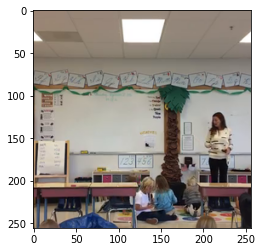

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# image index
idx = 75

class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']
img = Image.open(os.path.join(datadir, img_list.iloc[idx]))
plt.imshow(np.asarray(img))
print(class_list[labels[idx]])


## 4. Dataloader

<font size="3">Etant donné que notre mémoire risque de ne pas avoir assez d'espace, le package Pytorch permet d'envoyer les données directement vers le modèle d'apprentissage profond: Le GPU. Ceci rend le traitement des données dans la phase d'entraînement plus efficace. On a également fait de la "data augmentation" en utilisant les transformations d'image(Resize, RandomCrop, ColorJitter, RandomRotation, RandomHorizontalFlip)</font>



In [4]:

from PIL import Image
from torch.utils.data import Dataset, DataLoader
class ImageDataset(Dataset):
    def __init__(self, root_dir, files, labels=None, img_transform=None):
        self.root_dir = root_dir
        self.files = files
     
        self.labels = labels
        self.img_transform = img_transform
       

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.files.iloc[idx]))
       
        if self.img_transform is not None:
            img = self.img_transform(img)
       
        if self.labels is not None:
            return img,  int(self.labels[idx])
        else:
            return img

import torchvision

img_list_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


img_list_transform = torchvision.transforms.Compose([
   
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomCrop((222,222)),
    torchvision.transforms.ColorJitter(brightness=0.2),
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.RandomHorizontalFlip(0.5),
   
    
    torchvision.transforms.ToTensor(),
    
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_dataset = ImageDataset(root_dir=datadir,
                               files=img_list,
                               
                                 labels=labels,
                              img_transform=img_list_transform)

## 5. Training validation split
<font size="3">On définit la taille du "batch" à 112. C'est le nombre d'échantillons qui seront propagés à travers le réseau. Après avoir identifié la meilleure architecture et les hyperparamètres, on a mis le code qui divise notre Dataset en validation et training en commentaire vue le nombre limité de training data. </font>

In [5]:
#from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 112
#validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
#dataset_size = len(img_dataset)
#indices = list(range(dataset_size))
#split = int(np.floor(validation_split * dataset_size))
#if shuffle_dataset :
   # np.random.seed(random_seed)
   # np.random.shuffle(indices)
#train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
#train_sampler = SubsetRandomSampler(train_indices)
#valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(img_dataset, batch_size=batch_size, 
                                           num_workers=2)
#validation_loader = torch.utils.data.DataLoader(img_dataset, batch_size=batch_size,
                                               # sampler=valid_sampler,num_workers=2)


img_dataset_test = ImageDataset(root_dir=datadir,
                               files=img_list_test,
                            
                                
                              img_transform=img_list_transform,
                                 )
test_loader = torch.utils.data.DataLoader(img_dataset_test, batch_size=batch_size, 
                                           num_workers=2)

## 6. Charger un réseau pré-appris CNN

<font size="3">Tout d'abord, nous avons importé le réseau resnext50_32x4d. Ensuite, nous avons essayé plusieurs architectures, mais finalement nous avons décidé de supprimer la dernière couche et l'avons remplacé par notre propre architecture vu que cette dernière a abouti à une meilleure performance.</font>

In [6]:
import torchvision.models
import torch
import torch.nn as nn
import torch.nn.functional as F

resnext = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
#identify number of features in the last layer in order to extend the model
num_ftrs = resnext.fc.in_features


if device.type == 'cuda':
    resnext = resnext.cuda()

model = resnext

class MyModel(nn.Module):
            def __init__(self):
                super(MyModel, self).__init__()
                self.features = nn.Sequential(
                    # excludes the last layer
                    *list((model.children()))[:-1]
                    
                )
                #dont train on the original model
                for p in self.features :
                         p.requires_grad = False
                 #layers chosen to add       
                self.linear1 = nn.Linear(num_ftrs,32 )
               
                self.linear2 = nn.Linear(32,256 )
                
                self.linear3 = nn.Linear(256,32 )
               
                self.linear4 = nn.Linear(32,9 )
                
               
                
            def forward(self, x):
                x = self.features(x)
                x = x.view(-1,num_ftrs)
                x=F.leaky_relu(self.linear1(x))
               
                x=F.leaky_relu(self.linear2(x))
                x=F.leaky_relu(self.linear3(x))
                x=F.leaky_relu(self.linear4(x))
                
                return x

model = MyModel()


#print(mymodel)
model.to('cuda:0')
print("      ")

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

AssertionError: Torch not compiled with CUDA enabled

## 7. Training our network

<font size="3">Afin de ne pas avoir un overfitting, nous avons choisi un petit nombre d'Epochs. A la fin de chaque Epoch, on affiche l'"accuracy" du réseau pour bien se renseigner sur l'évolution des performances.<br>
On a tout d'abord décidé d'implémenter une méthode de "Early stopping" afin de mieux généraliser, mais les résultats montrent que le réseau généralise bien, même avec des performances supérieures à 99%.</font>


In [7]:
import torch.optim as optim
from tqdm import tqdm

optimizerCNN = optim.AdamW(model.parameters(), lr=0.00009)
criterion = nn.CrossEntropyLoss()
nbepoch = 5


for epoch in range(nbepoch):
    train_acc=0
    model.train()
    print("epoch", epoch)
    i=0
    for i, data in enumerate(tqdm(train_loader)):
        i+=1
        inputs,  targets = data
        inputs, targets = inputs.cuda(),targets.cuda()
        optimizerCNN.zero_grad()
        mespredictions = model(inputs)   
        loss = criterion(mespredictions,targets)    

        loss.backward() 
        optimizerCNN.step() 
        
        out, inds = torch.max(mespredictions,dim=1)
        train_acc += torch.sum(inds == targets)
       
        
        
        if random.randint(0,90)==0:
            print("\tloss=",loss) 
       
    final_train_acc = train_acc/(i*batch_size)
    
    
    #EARLY STOPPING (if accurracy at the end of epoch is more than 96%)
    
    #if(final_train_acc>0.96):
        #break
        
        
    print(final_train_acc)

  0%|          | 0/124 [00:00<?, ?it/s]

epoch 0


  0%|          | 0/124 [00:03<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled

## 8. Validation

<font size="3"> on observe la performance de CNN sur l'ensemble de  validation , en obtient en genrale la même accuracy
que celle de training. 

In [8]:
#from tqdm import tqdm

#feat = []
#i=0
#val_acc=0
#for i, data in enumerate(tqdm(validation_loader)):
#    i+=1
#    img,  targets = data
    #print(targets)
#    if device.type == 'cuda':
#        img, targets = img.cuda(),  targets.cuda()
#    with torch.no_grad():
#        outputs = model(img)
#    out, inds = torch.max(outputs,dim=1)
#    val_acc += torch.sum(inds == targets)
   
#    if device.type == 'cuda':
#        feat.append(outputs.cpu().numpy().squeeze())
#    else:
#        feat.append(outputs.numpy().squeeze())
#final_val_acc = val_acc/(i*batch_size)
#print(final_train_acc)

## 9. Importation des données audio

In [9]:
traindata = pd.read_csv(os.path.join(datadir,'data_train.csv'), delimiter=',', nrows = None)
data = np.array(traindata)

y_train = data[:,-1].astype('int32')

audio_train = data[:, 1:-1]


testdata = pd.read_csv(os.path.join(datadir,'data_test_novt.csv'), delimiter=',', nrows = None)
data = np.array(testdata)

audio_test = np.array(data[:, 1:], dtype='float64')



## 10. Extracting model output

<font size="3">On itère sur notre Train_loader, puis on extrait les prédictions données par le modèle, pour ensuite les concaténer avec les vecteurs audio et créer nos données hybrides.</font>

In [10]:
from tqdm import tqdm

feat = []
i=0
val_acc=0
model.eval()
for i, data in enumerate(tqdm(train_loader)):
    i+=1
    img, targets = data
    #print(targets)
    if device.type == 'cuda':
        img, targets = img.cuda(), targets.cuda()
    with torch.no_grad():
        outputs = model(img)
    out, inds = torch.max(outputs,dim=1)
    val_acc += torch.sum(inds == targets)
    
    if device.type == 'cuda':
        feat.append(outputs.cpu().numpy().squeeze())
    else:
        feat.append(outputs.numpy().squeeze())
final_val_acc = val_acc/(i*batch_size)
print(final_train_acc)

100%|██████████| 124/124 [42:01<00:00, 20.34s/it]


NameError: name 'final_train_acc' is not defined

## 15. Concaténation des données du training

In [11]:
imgfeat = np.concatenate(feat)

np.save(os.path.join('/kaggle/working/', 'img_feat'), imgfeat)
print(imgfeat.shape)

(13802, 9)


## 11. Transformation de l'audio

In [12]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(audio_train)

audio_train_scaled = scaler.transform(audio_train)
audio_test_scaled = scaler.transform(audio_test)

## 12. Concaténation de l'audio et des prédictions des images 

In [13]:
train_hh = np.concatenate((imgfeat,audio_train_scaled),axis=1)
print(train_hh.shape)

(13802, 113)


## 13. SVM appliqué sur audio-image data 


<font size="3"> on a mis le code qui divise notre data en training et validation en commentaire pour les même raison qu'avant

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Pour séparer les données en apprentissage et test
from sklearn.model_selection import train_test_split

#Xn, Xv, yn, yv = train_test_split(train_hh, y_train, random_state=42,test_size=0.1)

from sklearn import svm


svc = svm.SVC(kernel='rbf', max_iter=-1, verbose = True,gamma='scale',
             tol=1e-4,C=10.4,decision_function_shape='ovr')
svc.fit(train_hh, y_train)

score_train = svc.score(train_hh, y_train)
#score_test = svc.score(Xv, yv)
#print(c)
print("Taux de reco train=  {:.2f}%".format(score_train*100))
#print("Taux de reco =  {:.2f}%/{:.2f}% ".format(score_train*100,score_train*100))

[LibSVM]Taux de reco train=  99.96%


## 14. Extracting model output

<font size="3">On itère sur notre Test_loader, puis on extrait les prédictions données par le modèle, pour ensuite les concaténer avec les vecteurs audio et créer nos données hybrides.</font>

In [15]:
from tqdm import tqdm

feat_test = []
model.eval()
for i, data in enumerate(tqdm(test_loader)):

    img = data
    #print(targets)
    if device.type == 'cuda':
        img = img.cuda()
    with torch.no_grad():
        outputs = model(img)
   
   
    
    if device.type == 'cuda':
        feat_test.append(outputs.cpu())
    else:
        feat_test.append(outputs.numpy().squeeze())

100%|██████████| 31/31 [10:47<00:00, 20.87s/it]


## 15. Concaténation audio-image Test

In [16]:
imgfeat_test = np.concatenate(feat_test)
test_hh=np.concatenate((imgfeat_test,audio_test_scaled),axis=1)

print(test_hh.shape)

(3450, 113)


## 16. Prédiction finale du SVM

In [17]:
y_pred = svc.predict(test_hh)
print(y_pred.shape)

(3450,)


## 17. Création du fichier de soumission

In [18]:

submission = pd.DataFrame({'CLASS':y_pred})
submission=submission.reset_index()
submission = submission.rename(columns={'index': 'Id'})
submission.to_csv('My_submission.csv', index=False)